# Exploring My Fitbit Data

March 6, 2018

#### As a new Fitbit owner, previous collegiate athlete, and fitness lover, I am incredibly curious about my Fitbit data. I was especially curious about some potential analyses Fitbit did not already provide.

### The general outline of this notebook is as follows:
 1. Activity Level (i.e., Steps) and Sleep
 2. Cadence Change Over Time
 3. Summary and Next Steps
 
Note: In order to get my Fitbit data, I first had to set up a [Fitbit API](https://dev.fitbit.com/apps/new). Then, I ran a separate script - available [here](https://github.com/JessieRayeBauer/Fitbit/blob/master/Pull_fitbit_data.md).

### Import/install necessary libraries

In [28]:
#!pip install fitbit
#!pip install -r requirements/base.txt
#!pip install -r requirements/dev.txt
#!pip install -r requirements/test.txt
from time import sleep
import fitbit
import cherrypy
import requests
import json
import datetime
import scipy.stats
import pandas as pd
import numpy as np

# plotting
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# other
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.core import datetools
from scipy.stats import ttest_ind, ttest_ind_from_stats

## Question 1: Does the amount of sleep I get the night before predict my activity level?

Activity level is the number of steps taken. 

### Read in Sleep Data

In [2]:
sleepy = []
dates = pd.date_range('2017-12-23', '2018-02-10')

for date in dates:
    fname = 'sleep/sleep' + date.strftime('%Y-%m-%d') + '.json'
    with open(fname) as f:
        date_data_sleep = json.loads(f.read())
        datsleep = pd.read_json(date_data_sleep, typ='series')
        sleepy.append(datsleep['summary']['totalTimeInBed'])

sleepdf = pd.DataFrame(sleepy,index = dates) #use the date as the column row names
sleepdf.columns = ['hours'] #rename column
sleepdf['hours'] = sleepdf['hours']/60 # Turn minutes to hours

### Read in Step Data

In [3]:
steppers = []
for date in dates:
    fname = 'steps/step' + date.strftime('%Y-%m-%d') + '.json'
    with open(fname) as f:
        date_data = json.loads(f.read())
        stepsdata = pd.read_json(date_data, typ='series')
        steppers.append(stepsdata['activities-steps'][0]) # the zero indexes the first value

stepsdf = pd.DataFrame(steppers,index = dates) # use date as row index
stepsdf.columns = ['date','steps'] # rename columns

Add column for the day of week, and check structure.

In [4]:
stepsdf["day_of_week"] = stepsdf.index.weekday
days = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 
        5: "Saturday", 6: "Sunday"}
stepsdf["day_of_week"] = stepsdf.index.weekday
stepsdf["day_name"] = stepsdf["day_of_week"].apply(lambda x: days[x])

In [5]:
## add hours of sleep to steps df so I can just work with one df.
stepsdf['hours'] = sleepdf['hours'].values

Create variable for the previous nights' sleep and align it properly.

In [6]:
stepsdf["hours_prev"] = stepsdf.shift(1).hours
stepsdf.head()

,date,steps,day_of_week,day_name,hours,hours_prev
2017-12-23,2017-12-23,4238,5,Saturday,9.116667,NaN
2017-12-24,2017-12-24,10776,6,Sunday,9.250000,9.116667
2017-12-25,2017-12-25,4928,0,Monday,8.683333,9.250000
2017-12-26,2017-12-26,9468,1,Tuesday,9.966667,8.683333
2017-12-27,2017-12-27,7046,2,Wednesday,7.500000,9.966667


To perform any analyses or plot data, we need to convert steps column into a numeric type. Otherwise we get errors. We don't like errors.

In [7]:
stepsdf['steps'] = pd.to_numeric(stepsdf['steps'])

### Visualize the Sleep Data

Notice that the distribution appears to be bimodal. However, I happen to know that this is because I take naps, and those tend to be 2 hours or less. Also, my Fitbit broke, so it would sometimes run out of batteries in the middle of the night.

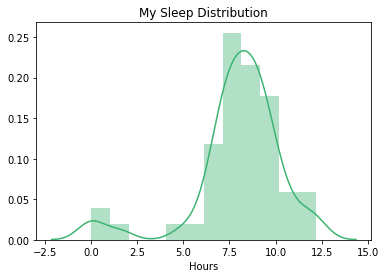

In [8]:
sns.distplot(stepsdf['hours'], color="mediumseagreen")
plt.title("My Sleep Distribution")
plt.xlabel("Hours")
plt.show()

For the purposes of this project, I will omit naps and/or artifically shortened sleep (less than 3 hours). 

In [9]:
stepsdf = stepsdf[stepsdf['hours'] > 3]

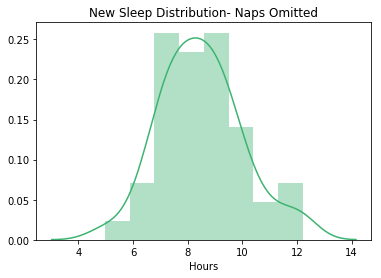

In [10]:
sns.distplot(stepsdf['hours'], color="mediumseagreen")
plt.title("New Sleep Distribution- Naps Omitted")
plt.xlabel("Hours")
plt.show()

#Looks pretty normal!

### Visualize the Step Data

Let's see my step distribution.

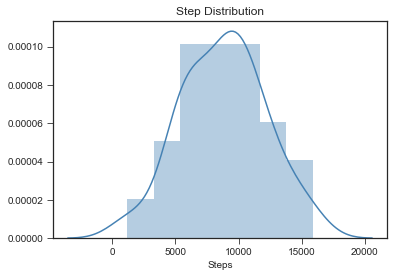

In [11]:
sns.set_style("ticks")
sns.distplot(stepsdf['steps'], color = 'steelblue')
plt.title("Step Distribution")
plt.xlabel("Steps") 
plt.show()

Sleep and Activity Data Over the Week

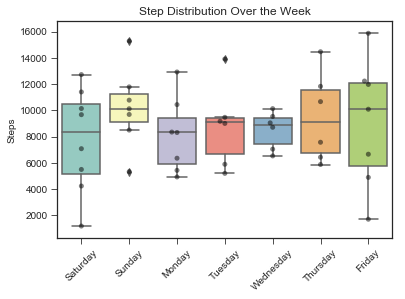

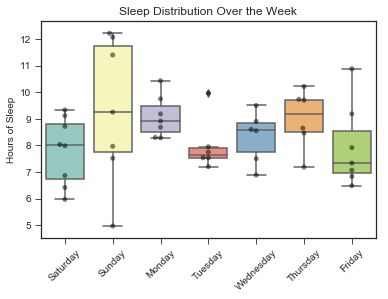

In [12]:
#Steps
sns.boxplot(x = 'day_name', y = 'steps', data = stepsdf, palette="Set3") 
 ## plot the dots over the box plots.
sns.swarmplot(x='day_name',
               y='steps', 
              data=stepsdf, 
              color='k',  #black dots
              alpha = 0.5)
plt.title('Step Distribution Over the Week')
plt.xticks(rotation=45)
plt.ylabel("Steps")
plt.xlabel("")
plt.show()

#Sleep
## plot the dots over the violin plot.
sns.boxplot(x = 'day_name', y = 'hours', data = stepsdf, palette = 'Set3')
 ## plot the dots over the box plots.
sns.swarmplot(x='day_name',
               y='hours', 
              data=stepsdf, 
              color='k',  #black dots
              alpha = 0.5)
# Customize Graph
plt.title("Sleep Distribution Over the Week")
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Hours of Sleep")
plt.show()

### Linear Regression Model

In [13]:
stepsdf_remove_NA = stepsdf[stepsdf['hours_prev'] > 0]

mod1 = smf.ols(formula = "steps ~ hours_prev", data = stepsdf_remove_NA).fit()
mod1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7635.0390,2824.494,2.703,0.010,1938.904,1.33e+04
hours_prev,160.7283,328.076,0.490,0.627,-500.900,822.357


## Question 1 Results: My sleep does not predict my activity level the next day.

So, we can see from the regression table that how many hours I slept the previous night ('hours_prev') does not significantly predict the amount of steps I take the next day ( *p* = .63). This might be for a variety of reasons. 

First, I don't have a lot of data yet! I have only used my Fitbit for a couple months. Second, I am a graduate student, and my sleep is incredibly variable. Third, I love to be active! Even if I am tired, a run usually makes me feel better. Long story short is, we need more data!

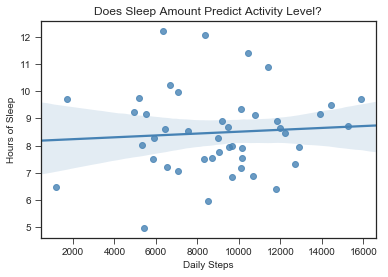

In [14]:
sns.regplot(x = 'steps', y = 'hours_prev', data = stepsdf_remove_NA, color = 'steelblue')
plt.xlabel("Daily Steps")
plt.ylabel("Hours of Sleep")
plt.title("Does Sleep Amount Predict Activity Level?")
plt.show()

That flat line shows that there is no linear relationship.

## Question 2: Has my cadence changed from my earlier training runs (in December) to my later training runs (in February)? 

Cadence is defined as the average number of times your feet hit the ground per minute. In the running community, it is widely believed that a quicker cadence is generally better. (For reference, elite athletes typically have an average cadence in the 180's.)

Below, I compared  three random runs from my earlier training and three random runs from my later training. Below is the code to read in my running data, create the data frames, create graphs, and conduct statistical testing.

### Read in Cadence Data

In [15]:
## Early Training Runs
## Run 1
with open('stepmins/test/stepMIN2017-12-24.json') as f:
    stepmin_dat_samplebefore = json.loads(f.read())
parsed_json_stepmin_before = json.loads(stepmin_dat_samplebefore)
stepminbefore = pd.DataFrame(parsed_json_stepmin_before['activities-steps-intraday']['dataset'])

### Visualize Cadence Data
View data from entire day to get a sense of the range of cadence values and activity levels. 

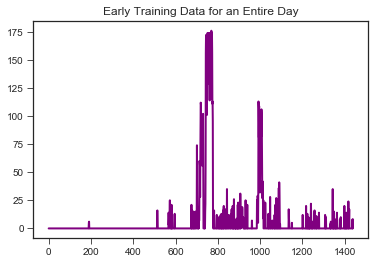

In [16]:
plt.plot('value', data=stepminbefore, marker='', color='purple', linewidth=2)
plt.title("Early Training Data for an Entire Day")
plt.show()

Anything less than 130 steps per minute shouldn't be treated as running, so we remove them. These are probably instances of walking my dog or light cardio/weights.

In [17]:
stepminbefore = stepminbefore[stepminbefore['value'] > 130]
stepminbefore = stepminbefore.reset_index(drop=True)

Read in the rest of the early training runs:

In [18]:
## Run 2
with open('stepmins/test/stepMIN2017-12-26.json') as f:
    stepmin_dat_samplebef1 = json.loads(f.read())
parsed_json_stepmin_bef1 = json.loads(stepmin_dat_samplebef1)
stepminbef1 = pd.DataFrame(parsed_json_stepmin_bef1['activities-steps-intraday']['dataset'])
stepminbef1 = stepminbef1[stepminbef1['value'] > 130]
stepminbef1 = stepminbef1.reset_index(drop=True)

## Run 3
with open('stepmins/test/stepMIN2017-12-29.json') as f:
    stepmin_dat_sampleBef2 = json.loads(f.read())
parsed_json_stepmin_bef2 = json.loads(stepmin_dat_sampleBef2)
stepminbef2 = pd.DataFrame(parsed_json_stepmin_bef2['activities-steps-intraday']['dataset'])
stepminbef2 = stepminbef2[stepminbef2['value'] > 130]
stepminbef2 = stepminbef2.reset_index(drop=True)

Read in later training runs:

In [19]:
## Run 1
with open('stepmins/test/stepMIN2018-03-01.json') as f:
    stepmin_dat_sampleAfter = json.loads(f.read())
parsed_json_stepmin_aft = json.loads(stepmin_dat_sampleAfter)
statstepaf = pd.DataFrame(parsed_json_stepmin_aft['activities-steps-intraday']['dataset'])
#Remove walking/shoe tie minutes
stepminaf = statstepaf[statstepaf['value'] > 130]
stepminaf = stepminaf.reset_index(drop=True)

## Run 2
with open('stepmins/test/stepMIN2018-02-08.json') as f:
    stepmin_dat_sampleAfter1 = json.loads(f.read())
parsed_json_stepmin_aft1 = json.loads(stepmin_dat_sampleAfter1)
statstepaf1 = pd.DataFrame(parsed_json_stepmin_aft1['activities-steps-intraday']['dataset'])
#remove walking/shoe tie minutes
stepminaf1 = statstepaf1[statstepaf1['value'] > 130]
stepminaf1 = stepminaf1.reset_index(drop=True)

## Run 3
with open('stepmins/test/stepMIN2018-02-22.json') as f:
    stepmin_dat_sampleAfter2 = json.loads(f.read())
parsed_json_stepmin_aft2 = json.loads(stepmin_dat_sampleAfter2)
statstepaf2 = pd.DataFrame(parsed_json_stepmin_aft2['activities-steps-intraday']['dataset'])
#remove walking/shoe tie minutes
stepminaf2 = statstepaf2[statstepaf2['value'] > 130]
stepminaf2 = stepminaf2.reset_index(drop=True)

### Create data frames

In [20]:
#Data frames for t-test 
beforeruns_test = pd.concat([stepminbefore, stepminbef1, stepminbef2])
afterruns_test = pd.concat([stepminaf, stepminaf1, stepminaf2])

##Data frame for graphs
graph_runs = pd.concat([stepminbefore, stepminbef1, stepminbef2,stepminaf, stepminaf1, stepminaf2], axis=1)
graph_runs.columns = ['timeb1', 'valueb1', 'timeb2', 'valueb2', 'timeb3', 'valueb3', 'timea1', 'valuea1',
                       'timea2', 'valuea2', 'timea3', 'valuea3']

### Visualize the Cadence Data


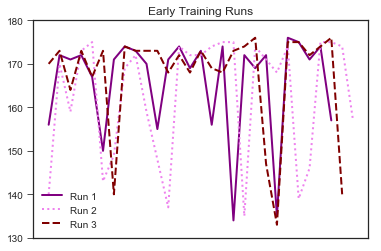

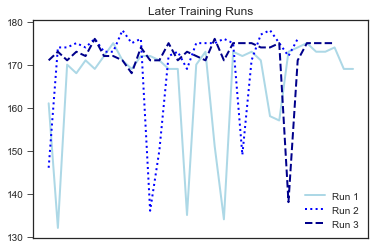

In [21]:
#Plot Early and Later Training Cadence During Runs
plt.plot('valueb1', data=graph_runs, marker='', color='purple', linewidth=2, label="Run 1")
plt.plot('valueb2', data=graph_runs, marker='', color='violet', linewidth=2,linestyle= 'dotted', label="Run 2")
plt.plot('valueb3', data=graph_runs, marker='', color='maroon', linewidth=2, linestyle='dashed', label="Run 3")
plt.legend()
plt.xticks([])
axes = plt.gca()
axes.set_ylim([130,180])
plt.title("Early Training Runs")
plt.show()

plt.plot('valuea1', data=graph_runs, marker='', color='lightblue', linewidth=2, label="Run 1")
plt.plot('valuea2', data=graph_runs, marker='', color='blue', linewidth=2,linestyle= 'dotted', label="Run 2")
plt.plot('valuea3', data=graph_runs, marker='', color='darkblue', linewidth=2, linestyle='dashed', label="Run 3")
plt.legend()
plt.xticks([])
plt.title("Later Training Runs")
plt.show()

It looks like there are fewer dips in my later training. The means of early and later training values (see below) are also different. However, we need to formally test this.

In [22]:
beforeruns_test["value"].mean(), afterruns_test["value"].mean() 

(165.39285714285714, 169.43617021276594)

In [23]:
ttest_ind(beforeruns_test['value'], afterruns_test['value'])

Ttest_indResult(statistic=-2.3771496771877398, pvalue=0.018519967370949606)

## Question 2 Results: Yes, there is a significant change in my cadence!

It looks like there is a significant difference between my cadence during earlier (M = 161.85) and later (M = 169.44) training runs (*p* = .02). My cadence has become quicker throughout my training. This is important for me as a runner as overstriding can lead to injury, and a quicker cadence means a faster pace!

## 3. Summary and Next steps
In sum, I imported data using Fitbit's API, worked with .json data, visualized my data, ran a linear regression, and performed a t-test. I found that (1) my activity level is independent from how much sleep I get, and (2) my cadence is slowly increasing over time.

What I would like to do next is collect more data! I would also like to create some interactive visuals and run some more sophisticated models on my data. Finally, I would like to more thoroughly explore my heart rate data. The closer I get to defending my dissertation, the higher it seems to get. Should be fun to test if that is statistically significant!

## Question 3: Do I need more sleep the night after I don't get a lot of sleep? In other words, am I building up a sleep deficit?


In the model below, I predict the difference in amount of sleep for a given day from the previous nights' hours of sleep. I will use an ordinary least squares regression model. Below is the code for the model, fitting the model, and displaying the results.

But first, we need to create a delta sleep variable to capture the difference in amount of sleep I got from the night before.



In [26]:
stepsdf["hours_diff"] = stepsdf.hours - stepsdf.hours_prev
stepsdf.head()

mod2 = smf.ols(formula = 'hours_diff ~ hours_prev', data = stepsdf).fit()
mod2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.8519,1.008,7.793,0.000,5.821,9.882
hours_prev,-0.9251,0.118,-7.818,0.000,-1.164,-0.687


### Question 1 Results: Yes, I have built up a sleep deficit.

The regression table shows that how many hours I slept the previous night ('hours_prev') negatively predicts the difference in amount of sleep I get the next day. Put more simply, this means that if I get a good night's sleep, the next night, I don't need as much sleep. Conversely, if I don't get a lot of sleep, the next night, I make up for it by sleeping longer.

To make this finding easier to digest, let us visualize the relationship!

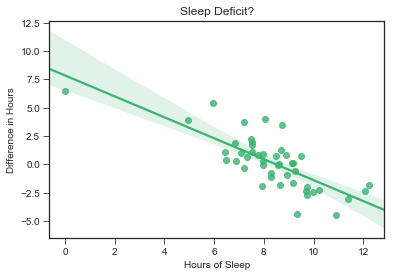

In [27]:
# Plot how much more I slept each night vs. amount slept night before
sns.regplot(x = stepsdf.hours_prev, y = stepsdf.hours_diff, color = "mediumseagreen")
plt.title("Sleep Deficit?")
plt.ylabel("Difference in Hours")
plt.xlabel("Hours of Sleep")
plt.show()


Here is the negtative linear relationship we saw in our regression table.